# Análisis de Sentimientos con Python y Pandas

Este notebook presenta un ejemplo completo de análisis de sentimientos usando técnicas de NLP (Natural Language Processing). Trabajaremos con un dataset real de reseñas de películas para clasificar textos como positivos o negativos.

## Objetivos del Proyecto
1. Preprocesar texto (limpieza, tokenización, eliminación de stopwords, lematización)
2. Vectorizar el texto usando diferentes técnicas (Bag of Words, TF-IDF, Word Embeddings)
3. Entrenar modelos de machine learning
4. Evaluar el rendimiento de los modelos
5. Realizar predicciones sobre nuevos textos


## 1. Instalación e Importación de Librerías

Primero, importamos todas las librerías necesarias para nuestro análisis.


In [ ]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Librerías para preprocesamiento de texto
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

# Librerías para vectorización
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

# Librerías para machine learning
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# Librería para descargar datasets reales (Hugging Face)
try:
    from datasets import load_dataset
    HAS_DATASETS = True
except ImportError:
    HAS_DATASETS = False
    print("⚠ 'datasets' no está instalado. Instálalo con: pip install datasets")

# Descargar recursos de NLTK necesarios
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet', quiet=True)

# Descargar POS tagger (necesario para lematización mejorada)
# En versiones recientes de NLTK puede ser 'averaged_perceptron_tagger_eng'
try:
    nltk.data.find('taggers/averaged_perceptron_tagger_eng')
except LookupError:
    try:
        nltk.download('averaged_perceptron_tagger_eng', quiet=True)
    except:
        try:
            nltk.data.find('taggers/averaged_perceptron_tagger')
        except LookupError:
            nltk.download('averaged_perceptron_tagger', quiet=True)

print("✓ Todas las librerías han sido importadas correctamente")


✓ Todas las librerías han sido importadas correctamente


## 2. Carga del Dataset

Utilizaremos el dataset de reseñas de películas de IMDb desde Hugging Face. Este dataset contiene 50,000 reseñas etiquetadas como positivas (1) o negativas (0).

**Requisitos previos:**
- Instalar la librería datasets: `pip install datasets`
- El dataset se descargará automáticamente la primera vez que ejecutes el código


In [8]:
# Cargar dataset de IMDb desde Hugging Face
# Este dataset contiene 50,000 reseñas de películas etiquetadas como positivas (1) o negativas (0)

print("=" * 60)
print("DESCARGANDO Y CARGANDO DATASET DE IMDb")
print("=" * 60)

if not HAS_DATASETS:
    print("\n⚠ ERROR: La librería 'datasets' no está instalada.")
    print("\nPor favor, instálala con:")
    print("  pip install datasets")
    print("\nEsta librería descargará automáticamente el dataset de IMDb desde Hugging Face.")
    raise ImportError("Por favor, instala 'datasets' con: pip install datasets")

try:
    print("\nDescargando dataset de IMDb desde Hugging Face...")
    print("  (Esto puede tardar unos momentos la primera vez)")
    
    # Cargar dataset de IMDb
    dataset = load_dataset("imdb")
    
    print("✓ Dataset descargado exitosamente")
    
    # Convertir a pandas DataFrame
    print("\nConvirtiendo a pandas DataFrame...")
    train_df = pd.DataFrame(dataset['train'])
    test_df = pd.DataFrame(dataset['test'])
    
    # Combinar train y test en un solo DataFrame
    df = pd.concat([train_df, test_df], ignore_index=True)
    
    # El dataset de Hugging Face usa 'text' para las reseñas y 'label' para el sentimiento
    # Renombrar columnas para mantener consistencia
    df = df.rename(columns={'text': 'review', 'label': 'sentiment'})
    
    # En el dataset de IMDb: label 1 = positivo, label 0 = negativo (ya está correcto)
    # No necesitamos convertir nada, ya está en el formato correcto
    
    print(f"✓ Dataset convertido a DataFrame exitosamente")
    
    # Mostrar información del dataset
    print("\n" + "=" * 60)
    print("DATASET CARGADO EXITOSAMENTE")
    print("=" * 60)
    print(f"\nTotal de reseñas: {len(df)}")
    print(f"  - Entrenamiento: {len(train_df)} reseñas")
    print(f"  - Prueba: {len(test_df)} reseñas")
    print(f"\nPrimeras filas del dataset:")
    print(df.head())
    print(f"\nDistribución de sentimientos:")
    print(df['sentiment'].value_counts())
    print(f"  - Positivas (1): {df[df['sentiment'] == 1].shape[0]}")
    print(f"  - Negativas (0): {df[df['sentiment'] == 0].shape[0]}")
    print(f"\nInformación del dataset:")
    print(df.info())
    print(f"\nValores nulos:")
    print(df.isnull().sum())
    
except Exception as e:
    print(f"\n✗ Error al cargar el dataset: {e}")
    print("\nPosibles causas:")
    print("  1. Problema de conexión a internet")
    print("  2. Error en la descarga del dataset")
    print("\nSolución:")
    print("  Asegúrate de tener conexión a internet y vuelve a intentar.")
    raise


DESCARGANDO Y CARGANDO DATASET DE IMDb

Descargando dataset de IMDb desde Hugging Face...
  (Esto puede tardar unos momentos la primera vez)


Generating unsupervised split: 100%|██████████| 50000/50000 [00:00<00:00, 432495.22 examples/s]


✓ Dataset descargado exitosamente

Convirtiendo a pandas DataFrame...
✓ Dataset convertido a DataFrame exitosamente

DATASET CARGADO EXITOSAMENTE

Total de reseñas: 50000
  - Entrenamiento: 25000 reseñas
  - Prueba: 25000 reseñas

Primeras filas del dataset:
                                              review  sentiment
0  I rented I AM CURIOUS-YELLOW from my video sto...          0
1  "I Am Curious: Yellow" is a risible and preten...          0
2  If only to avoid making this type of film in t...          0
3  This film was probably inspired by Godard's Ma...          0
4  Oh, brother...after hearing about this ridicul...          0

Distribución de sentimientos:
sentiment
0    25000
1    25000
Name: count, dtype: int64
  - Positivas (1): 25000
  - Negativas (0): 25000

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   r

In [9]:
# Exploración inicial del dataset
print("=" * 60)
print("INFORMACIÓN DEL DATASET")
print("=" * 60)
print(f"\nDimensiones: {df.shape}")
print(f"\nInformación del DataFrame:")
print(df.info())
print(f"\nEstadísticas descriptivas:")
print(df.describe())
print(f"\nValores nulos:")
print(df.isnull().sum())
print(f"\nEjemplos de reseñas:")
for i in range(3):
    print(f"\nReseña {i+1} (Sentimiento: {'Positivo' if df.iloc[i]['sentiment'] == 1 else 'Negativo'}):")
    print(df.iloc[i]['review'][:200])


INFORMACIÓN DEL DATASET

Dimensiones: (50000, 2)

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB
None

Estadísticas descriptivas:
          sentiment
count  50000.000000
mean       0.500000
std        0.500005
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000

Valores nulos:
review       0
sentiment    0
dtype: int64

Ejemplos de reseñas:

Reseña 1 (Sentimiento: Negativo):
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev

Reseña 2 (Sentimiento: Negativo):
"I Am Curious: Yellow" is a risible and pr

## 3. Preprocesamiento de Texto

El preprocesamiento es crucial para mejorar la calidad de los datos antes de entrenar el modelo. Incluye varios pasos:

### 3.1 Limpieza de Texto

Eliminamos caracteres especiales, URLs, números, y convertimos todo a minúsculas.


In [10]:
def limpiar_texto(texto):
    """
    Limpia el texto eliminando caracteres especiales, URLs, números, etc.
    
    Parámetros:
    -----------
    texto : str
        Texto a limpiar
    
    Retorna:
    --------
    str
        Texto limpio
    """
    if pd.isna(texto):
        return ""
    
    # Convertir a string si no lo es
    texto = str(texto)
    
    # Convertir a minúsculas
    texto = texto.lower()
    
    # Eliminar URLs
    texto = re.sub(r'http\S+|www.\S+', '', texto)
    
    # Eliminar emails
    texto = re.sub(r'\S+@\S+', '', texto)
    
    # Eliminar números
    texto = re.sub(r'\d+', '', texto)
    
    # Eliminar caracteres especiales excepto espacios y apostrofes
    texto = re.sub(r'[^a-zA-Z\s\']', '', texto)
    
    # Eliminar espacios múltiples
    texto = re.sub(r'\s+', ' ', texto)
    
    # Eliminar espacios al inicio y final
    texto = texto.strip()
    
    return texto

# Aplicar limpieza
print("Limpiando texto...")
df['review_limpio'] = df['review'].apply(limpiar_texto)

# Mostrar ejemplos antes y después
print("\n" + "=" * 60)
print("EJEMPLOS DE LIMPIEZA")
print("=" * 60)
for i in range(3):
    print(f"\nEjemplo {i+1}:")
    print(f"Original: {df.iloc[i]['review'][:150]}")
    print(f"Limpio:   {df.iloc[i]['review_limpio'][:150]}")

print(f"\n✓ Limpieza completada. Reseñas procesadas: {len(df)}")


Limpiando texto...

EJEMPLOS DE LIMPIEZA

Ejemplo 1:
Original: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard th
Limpio:   i rented i am curiousyellow from my video store because of all the controversy that surrounded it when it was first released in i also heard that at f

Ejemplo 2:
Original: "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be ta
Limpio:   i am curious yellow is a risible and pretentious steaming pile it doesn't matter what one's political views are because this film can hardly be taken 

Ejemplo 3:
Original: If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might fee
Limpio:   if only to avoid making this type of film in the future this film is interesting as an experiment but tells 

### 3.2 Tokenización

Dividimos el texto en palabras individuales (tokens).


In [11]:
def tokenizar(texto):
    """
    Tokeniza el texto dividiéndolo en palabras individuales.
    
    Parámetros:
    -----------
    texto : str
        Texto a tokenizar
    
    Retorna:
    --------
    list
        Lista de tokens (palabras)
    """
    if not texto or texto == "":
        return []
    
    # Tokenizar usando NLTK
    tokens = word_tokenize(texto)
    
    # Filtrar tokens vacíos
    tokens = [token for token in tokens if token.strip()]
    
    return tokens

# Aplicar tokenización
print("Tokenizando texto...")
df['tokens'] = df['review_limpio'].apply(tokenizar)

# Mostrar ejemplos
print("\n" + "=" * 60)
print("EJEMPLOS DE TOKENIZACIÓN")
print("=" * 60)
for i in range(2):
    print(f"\nEjemplo {i+1}:")
    print(f"Texto: {df.iloc[i]['review_limpio'][:100]}")
    print(f"Tokens ({len(df.iloc[i]['tokens'])} tokens): {df.iloc[i]['tokens'][:20]}...")

print(f"\n✓ Tokenización completada")


Tokenizando texto...

EJEMPLOS DE TOKENIZACIÓN

Ejemplo 1:
Texto: i rented i am curiousyellow from my video store because of all the controversy that surrounded it wh
Tokens (288 tokens): ['i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was']...

Ejemplo 2:
Texto: i am curious yellow is a risible and pretentious steaming pile it doesn't matter what one's politica
Tokens (224 tokens): ['i', 'am', 'curious', 'yellow', 'is', 'a', 'risible', 'and', 'pretentious', 'steaming', 'pile', 'it', 'does', "n't", 'matter', 'what', 'one', "'s", 'political', 'views']...

✓ Tokenización completada


### 3.3 Eliminación de Stopwords

Las stopwords son palabras comunes que no aportan información significativa (como "the", "is", "at", etc.). Las eliminamos para reducir el ruido.


In [12]:
def eliminar_stopwords(tokens):
    """
    Elimina las stopwords (palabras comunes) de la lista de tokens.
    
    Parámetros:
    -----------
    tokens : list
        Lista de tokens
    
    Retorna:
    --------
    list
        Lista de tokens sin stopwords
    """
    # Obtener stopwords en inglés
    stop_words = set(stopwords.words('english'))
    
    # Filtrar tokens que no sean stopwords
    tokens_filtrados = [token for token in tokens if token.lower() not in stop_words]
    
    return tokens_filtrados

# Aplicar eliminación de stopwords
print("Eliminando stopwords...")
df['tokens_sin_stopwords'] = df['tokens'].apply(eliminar_stopwords)

# Mostrar ejemplos
print("\n" + "=" * 60)
print("EJEMPLOS DE ELIMINACIÓN DE STOPWORDS")
print("=" * 60)
for i in range(2):
    print(f"\nEjemplo {i+1}:")
    print(f"Antes ({len(df.iloc[i]['tokens'])} tokens): {df.iloc[i]['tokens'][:15]}")
    print(f"Después ({len(df.iloc[i]['tokens_sin_stopwords'])} tokens): {df.iloc[i]['tokens_sin_stopwords'][:15]}")
    print(f"Tokens eliminados: {len(df.iloc[i]['tokens']) - len(df.iloc[i]['tokens_sin_stopwords'])}")

print(f"\n✓ Eliminación de stopwords completada")


Eliminando stopwords...

EJEMPLOS DE ELIMINACIÓN DE STOPWORDS

Ejemplo 1:
Antes (288 tokens): ['i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that']
Después (151 tokens): ['rented', 'curiousyellow', 'video', 'store', 'controversy', 'surrounded', 'first', 'released', 'also', 'heard', 'first', 'seized', 'us', 'customs', 'ever']
Tokens eliminados: 137

Ejemplo 2:
Antes (224 tokens): ['i', 'am', 'curious', 'yellow', 'is', 'a', 'risible', 'and', 'pretentious', 'steaming', 'pile', 'it', 'does', "n't", 'matter']
Después (124 tokens): ['curious', 'yellow', 'risible', 'pretentious', 'steaming', 'pile', "n't", 'matter', 'one', "'s", 'political', 'views', 'film', 'hardly', 'taken']
Tokens eliminados: 100

✓ Eliminación de stopwords completada


### 3.4 Lematización

La lematización reduce las palabras a su forma base o raíz (por ejemplo, "running" → "run", "better" → "good"). Esto ayuda a normalizar el texto.


In [15]:
def obtener_pos_tag(word):
    """
    Obtiene la etiqueta POS (Part-of-Speech) para una palabra.
    Necesario para una lematización más precisa.
    """
    try:
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    except LookupError:
        # Si no está disponible el POS tagger, usar NOUN por defecto
        return wordnet.NOUN

def lematizar(tokens):
    """
    Lematiza los tokens reduciéndolos a su forma base.
    
    Parámetros:
    -----------
    tokens : list
        Lista de tokens
    
    Retorna:
    --------
    list
        Lista de tokens lematizados
    """
    lemmatizer = WordNetLemmatizer()
    tokens_lematizados = []
    
    # Intentar usar POS tagging para lematización más precisa
    usar_pos = True
    try:
        # Verificar si el POS tagger está disponible
        nltk.pos_tag(['test'])
    except LookupError:
        usar_pos = False
        print("  ⚠ Advertencia: POS tagger no disponible. Usando lematización simple.")
        # Intentar descargar el recurso
        try:
            nltk.download('averaged_perceptron_tagger_eng', quiet=True)
            usar_pos = True
        except:
            try:
                nltk.download('averaged_perceptron_tagger', quiet=True)
                usar_pos = True
            except:
                pass
    
    for token in tokens:
        if usar_pos:
            # Obtener la etiqueta POS para una lematización más precisa
            pos = obtener_pos_tag(token)
            # Lematizar
            token_lematizado = lemmatizer.lemmatize(token.lower(), pos)
        else:
            # Lematización simple sin POS tagging (menos precisa pero funciona)
            token_lematizado = lemmatizer.lemmatize(token.lower())
        tokens_lematizados.append(token_lematizado)
    
    return tokens_lematizados

# Aplicar lematización
print("Lematizando tokens...")
df['tokens_lematizados'] = df['tokens_sin_stopwords'].apply(lematizar)

# Mostrar ejemplos
print("\n" + "=" * 60)
print("EJEMPLOS DE LEMATIZACIÓN")
print("=" * 60)
for i in range(2):
    print(f"\nEjemplo {i+1}:")
    print(f"Antes: {df.iloc[i]['tokens_sin_stopwords'][:15]}")
    print(f"Después: {df.iloc[i]['tokens_lematizados'][:15]}")

print(f"\n✓ Lematización completada")


Lematizando tokens...
  ⚠ Advertencia: POS tagger no disponible. Usando lematización simple.

EJEMPLOS DE LEMATIZACIÓN

Ejemplo 1:
Antes: ['rented', 'curiousyellow', 'video', 'store', 'controversy', 'surrounded', 'first', 'released', 'also', 'heard', 'first', 'seized', 'us', 'customs', 'ever']
Después: ['rent', 'curiousyellow', 'video', 'store', 'controversy', 'surround', 'first', 'release', 'also', 'heard', 'first', 'seize', 'u', 'custom', 'ever']

Ejemplo 2:
Antes: ['curious', 'yellow', 'risible', 'pretentious', 'steaming', 'pile', "n't", 'matter', 'one', "'s", 'political', 'views', 'film', 'hardly', 'taken']
Después: ['curious', 'yellow', 'risible', 'pretentious', 'steam', 'pile', "n't", 'matter', 'one', "'s", 'political', 'view', 'film', 'hardly', 'take']

✓ Lematización completada


### 3.5 Texto Final Preprocesado

Combinamos los tokens lematizados en texto nuevamente para usar en la vectorización.


In [16]:
# Convertir tokens lematizados de vuelta a texto
df['texto_preprocesado'] = df['tokens_lematizados'].apply(lambda tokens: ' '.join(tokens))

# Mostrar resumen del preprocesamiento
print("=" * 60)
print("RESUMEN DEL PREPROCESAMIENTO")
print("=" * 60)

for i in range(2):
    print(f"\n{'='*60}")
    print(f"RESEÑA {i+1} - Sentimiento: {'Positivo' if df.iloc[i]['sentiment'] == 1 else 'Negativo'}")
    print(f"{'='*60}")
    print(f"Original:\n{df.iloc[i]['review'][:200]}")
    print(f"\nLimpio:\n{df.iloc[i]['review_limpio'][:200]}")
    print(f"\nPreprocesado final:\n{df.iloc[i]['texto_preprocesado'][:200]}")

print(f"\n✓ Preprocesamiento completo. Total de reseñas procesadas: {len(df)}")


RESUMEN DEL PREPROCESAMIENTO

RESEÑA 1 - Sentimiento: Negativo
Original:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev

Limpio:
i rented i am curiousyellow from my video store because of all the controversy that surrounded it when it was first released in i also heard that at first it was seized by us customs if it ever tried 

Preprocesado final:
rent curiousyellow video store controversy surround first release also heard first seize u custom ever try enter country therefore fan film consider controversial really see myselfbr br plot center ar

RESEÑA 2 - Sentimiento: Negativo
Original:
"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that 

Limpio:
i am curious yellow is a risible and pre

## 4. Vectorización

La vectorización convierte el texto preprocesado en representaciones numéricas que los algoritmos de machine learning pueden entender. Exploraremos diferentes técnicas:

### 4.1 Bag of Words (BoW)

La bolsa de palabras representa cada documento como un vector que cuenta la frecuencia de cada palabra en el vocabulario.


In [17]:
# Crear vectorizador Bag of Words
# max_features: número máximo de palabras más frecuentes a considerar
# min_df: frecuencia mínima de documentos para incluir una palabra
# max_df: frecuencia máxima de documentos para incluir una palabra
bow_vectorizer = CountVectorizer(
    max_features=5000,  # Usar las 5000 palabras más frecuentes
    min_df=2,           # Palabra debe aparecer en al menos 2 documentos
    max_df=0.95         # Palabra no debe aparecer en más del 95% de documentos
)

print("Vectorizando usando Bag of Words...")
X_bow = bow_vectorizer.fit_transform(df['texto_preprocesado'])

print(f"\n✓ Bag of Words completado")
print(f"Dimensiones de la matriz: {X_bow.shape}")
print(f"Número de características (palabras): {len(bow_vectorizer.vocabulary_)}")

# Mostrar algunas palabras del vocabulario
vocabulario_bow = list(bow_vectorizer.vocabulary_.keys())[:20]
print(f"\nPrimeras 20 palabras del vocabulario: {vocabulario_bow}")

# Mostrar ejemplo de vectorización para una reseña
print(f"\nEjemplo de vectorización (primeras 20 características):")
print(X_bow[0].toarray()[0][:20])


Vectorizando usando Bag of Words...

✓ Bag of Words completado
Dimensiones de la matriz: (50000, 5000)
Número de características (palabras): 5000

Primeras 20 palabras del vocabulario: ['rent', 'video', 'store', 'surround', 'first', 'release', 'also', 'heard', 'ever', 'try', 'enter', 'country', 'therefore', 'fan', 'film', 'consider', 'controversial', 'really', 'see', 'br']

Ejemplo de vectorización (primeras 20 características):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### 4.2 TF-IDF (Term Frequency-Inverse Document Frequency)

TF-IDF mide la importancia de una palabra en un documento considerando tanto su frecuencia local (TF) como su frecuencia global en todo el corpus (IDF). Las palabras muy comunes tienen menor peso.


In [18]:
# Crear vectorizador TF-IDF
# ngram_range: considerar unigramas (1,1) o también bigramas (1,2), etc.
# max_features: número máximo de características
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,      # Usar las 5000 palabras más importantes según TF-IDF
    min_df=2,               # Palabra debe aparecer en al menos 2 documentos
    max_df=0.95,            # Palabra no debe aparecer en más del 95% de documentos
    ngram_range=(1, 2),     # Usar unigramas y bigramas (palabras y pares de palabras)
    stop_words='english'    # Ya eliminamos stopwords, pero esto es redundancia
)

print("Vectorizando usando TF-IDF...")
X_tfidf = tfidf_vectorizer.fit_transform(df['texto_preprocesado'])

print(f"\n✓ TF-IDF completado")
print(f"Dimensiones de la matriz: {X_tfidf.shape}")
print(f"Número de características: {len(tfidf_vectorizer.vocabulary_)}")

# Mostrar algunas características importantes
caracteristicas_tfidf = list(tfidf_vectorizer.vocabulary_.keys())[:30]
print(f"\nPrimeras 30 características (palabras/ngramas): {caracteristicas_tfidf}")

# Mostrar ejemplo de vectorización TF-IDF para una reseña
print(f"\nEjemplo de vectorización TF-IDF (primeras 20 características):")
print(X_tfidf[0].toarray()[0][:20])

# Las características con valores más altos son las más importantes para ese documento
valores_ordenados = sorted(enumerate(X_tfidf[0].toarray()[0]), key=lambda x: x[1], reverse=True)
top_caracteristicas = valores_ordenados[:10]
print(f"\nTop 10 características más importantes para la primera reseña:")
for idx, valor in top_caracteristicas:
    palabra = [k for k, v in tfidf_vectorizer.vocabulary_.items() if v == idx]
    if palabra:
        print(f"  {palabra[0]}: {valor:.4f}")


Vectorizando usando TF-IDF...

✓ TF-IDF completado
Dimensiones de la matriz: (50000, 5000)
Número de características: 5000

Primeras 30 características (palabras/ngramas): ['rent', 'video', 'store', 'surround', 'release', 'heard', 'try', 'enter', 'country', 'fan', 'film', 'consider', 'controversial', 'really', 'br', 'plot', 'center', 'young', 'swedish', 'drama', 'student', 'want', 'learn', 'life', 'particular', 'focus', 'attention', 'make', 'sort', 'documentary']

Ejemplo de vectorización TF-IDF (primeras 20 características):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Top 10 características más importantes para la primera reseña:
  swedish: 0.3474
  sex: 0.3469
  nudity: 0.1700
  issue: 0.1600
  shock: 0.1511
  cinema: 0.1390
  drama: 0.1380
  consider: 0.1339
  want: 0.1331
  arguably: 0.1142


### 4.3 Word Embeddings (Word2Vec)

Los Word Embeddings representan palabras como vectores densos en un espacio continuo donde palabras similares están cerca. Word2Vec es una técnica popular para aprender estos embeddings.


In [19]:
# Entrenar modelo Word2Vec
# Este modelo aprenderá representaciones vectoriales de palabras basándose en el contexto

print("Entrenando modelo Word2Vec...")
print("Este proceso puede tardar unos momentos...")

# Word2Vec requiere una lista de listas de tokens
corpus_tokens = df['tokens_lematizados'].tolist()

# Configuración del modelo Word2Vec
# vector_size: dimensión de los vectores de palabras
# window: tamaño de la ventana de contexto
# min_count: frecuencia mínima de una palabra para incluirla
# workers: número de hilos de procesamiento
# sg: 0 para CBOW, 1 para Skip-gram
word2vec_model = Word2Vec(
    sentences=corpus_tokens,
    vector_size=100,      # Vectores de 100 dimensiones
    window=5,             # Ventana de contexto de 5 palabras
    min_count=2,          # Palabra debe aparecer al menos 2 veces
    workers=4,            # Usar 4 hilos
    sg=0                  # 0 = CBOW, 1 = Skip-gram
)

print(f"\n✓ Modelo Word2Vec entrenado")
print(f"Tamaño del vocabulario: {len(word2vec_model.wv.key_to_index)}")
print(f"Dimensión de los vectores: {word2vec_model.wv.vector_size}")

# Mostrar algunas palabras similares como ejemplo
print(f"\nEjemplos de palabras similares:")
palabras_ejemplo = list(word2vec_model.wv.key_to_index.keys())[:10]
for palabra in palabras_ejemplo[:5]:
    try:
        similares = word2vec_model.wv.most_similar(palabra, topn=3)
        print(f"\nPalabras similares a '{palabra}':")
        for sim_palabra, sim_score in similares:
            print(f"  {sim_palabra}: {sim_score:.4f}")
    except:
        pass


Entrenando modelo Word2Vec...
Este proceso puede tardar unos momentos...

✓ Modelo Word2Vec entrenado
Tamaño del vocabulario: 66066
Dimensión de los vectores: 100

Ejemplos de palabras similares:

Palabras similares a ''s':
  blehbr: 0.4042
  although: 0.3927
  lamore: 0.3899

Palabras similares a 'br':
  spoiler: 0.4464
  anyway: 0.4208
  azjazz: 0.4047

Palabras similares a 'movie':
  film: 0.8238
  moviebr: 0.7866
  flick: 0.6524

Palabras similares a 'film':
  movie: 0.8238
  filmbr: 0.6928
  moviebr: 0.6433

Palabras similares a 'n't':
  dont: 0.6703
  nobody: 0.5658
  hardly: 0.5510


### 4.4 Crear Vectores de Documentos usando Word Embeddings

Para usar Word2Vec en clasificación, necesitamos representar cada documento (reseña) como un vector. Usaremos el promedio de los vectores de las palabras en el documento.


In [20]:
def documento_a_vector(tokens, modelo_w2v):
    """
    Convierte un documento (lista de tokens) en un vector promediando
    los embeddings de las palabras que contiene.
    
    Parámetros:
    -----------
    tokens : list
        Lista de tokens del documento
    modelo_w2v : Word2Vec
        Modelo Word2Vec entrenado
    
    Retorna:
    --------
    numpy.array
        Vector del documento
    """
    vector_size = modelo_w2v.wv.vector_size
    vector_doc = np.zeros(vector_size)
    palabras_encontradas = 0
    
    for token in tokens:
        if token in modelo_w2v.wv.key_to_index:
            vector_doc += modelo_w2v.wv[token]
            palabras_encontradas += 1
    
    if palabras_encontradas > 0:
        vector_doc = vector_doc / palabras_encontradas  # Promedio
    
    return vector_doc

# Crear matriz de vectores para todos los documentos
print("Creando vectores de documentos usando Word2Vec...")
X_word2vec = np.array([documento_a_vector(tokens, word2vec_model) 
                       for tokens in corpus_tokens])

print(f"\n✓ Vectores de documentos creados")
print(f"Dimensiones de la matriz: {X_word2vec.shape}")
print(f"Cada documento está representado por un vector de {X_word2vec.shape[1]} dimensiones")


Creando vectores de documentos usando Word2Vec...

✓ Vectores de documentos creados
Dimensiones de la matriz: (50000, 100)
Cada documento está representado por un vector de 100 dimensiones


## 5. Preparación de Datos para Entrenamiento

Dividimos los datos en conjuntos de entrenamiento y prueba para evaluar el rendimiento del modelo.


In [21]:
# Preparar las etiquetas (sentimientos)
y = df['sentiment'].values

print("=" * 60)
print("PREPARACIÓN DE DATOS")
print("=" * 60)

# Dividir datos para cada método de vectorización
# Usaremos 80% para entrenamiento y 20% para prueba

# 1. Bag of Words
X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    X_bow, y, test_size=0.2, random_state=42, stratify=y
)

# 2. TF-IDF
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Word2Vec
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_word2vec, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nConjunto de entrenamiento: {len(y_train)} muestras")
print(f"Conjunto de prueba: {len(y_test)} muestras")
print(f"\nDistribución de sentimientos en entrenamiento:")
print(f"  Positivos (1): {np.sum(y_train == 1)}")
print(f"  Negativos (0): {np.sum(y_train == 0)}")
print(f"\nDistribución de sentimientos en prueba:")
print(f"  Positivos (1): {np.sum(y_test == 1)}")
print(f"  Negativos (0): {np.sum(y_test == 0)}")


PREPARACIÓN DE DATOS

Conjunto de entrenamiento: 40000 muestras
Conjunto de prueba: 10000 muestras

Distribución de sentimientos en entrenamiento:
  Positivos (1): 20000
  Negativos (0): 20000

Distribución de sentimientos en prueba:
  Positivos (1): 5000
  Negativos (0): 5000


## 6. Entrenamiento de Modelos

Entrenaremos diferentes modelos de machine learning usando las diferentes técnicas de vectorización. Compararemos su rendimiento.

### 6.1 Modelo con Bag of Words


In [22]:
# Entrenar Naive Bayes con Bag of Words
print("=" * 60)
print("ENTRENAMIENTO: Naive Bayes con Bag of Words")
print("=" * 60)

modelo_bow = MultinomialNB()
modelo_bow.fit(X_train_bow, y_train)

# Realizar predicciones
y_pred_bow = modelo_bow.predict(X_test_bow)

print(f"\n✓ Modelo entrenado exitosamente")

# Calcular métricas
accuracy_bow = accuracy_score(y_test, y_pred_bow)
precision_bow = precision_score(y_test, y_pred_bow)
recall_bow = recall_score(y_test, y_pred_bow)
f1_bow = f1_score(y_test, y_pred_bow)

print(f"\nMétricas de rendimiento (BoW + Naive Bayes):")
print(f"  Precisión (Accuracy): {accuracy_bow:.4f}")
print(f"  Precisión (Precision): {precision_bow:.4f}")
print(f"  Recall: {recall_bow:.4f}")
print(f"  F1-Score: {f1_bow:.4f}")


ENTRENAMIENTO: Naive Bayes con Bag of Words

✓ Modelo entrenado exitosamente

Métricas de rendimiento (BoW + Naive Bayes):
  Precisión (Accuracy): 0.8431
  Precisión (Precision): 0.8472
  Recall: 0.8372
  F1-Score: 0.8422


### 6.2 Modelo con TF-IDF


In [23]:
# Entrenar múltiples modelos con TF-IDF para comparar
print("=" * 60)
print("ENTRENAMIENTO: Múltiples Modelos con TF-IDF")
print("=" * 60)

modelos_tfidf = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

resultados_tfidf = {}

for nombre, modelo in modelos_tfidf.items():
    print(f"\nEntrenando {nombre}...")
    modelo.fit(X_train_tfidf, y_train_tfidf)
    y_pred = modelo.predict(X_test_tfidf)
    
    # Calcular métricas
    resultados_tfidf[nombre] = {
        'modelo': modelo,
        'accuracy': accuracy_score(y_test_tfidf, y_pred),
        'precision': precision_score(y_test_tfidf, y_pred),
        'recall': recall_score(y_test_tfidf, y_pred),
        'f1': f1_score(y_test_tfidf, y_pred),
        'y_pred': y_pred
    }
    
    print(f"  ✓ {nombre} entrenado")
    print(f"    Accuracy: {resultados_tfidf[nombre]['accuracy']:.4f}")
    print(f"    F1-Score: {resultados_tfidf[nombre]['f1']:.4f}")

# Mostrar comparación
print("\n" + "=" * 60)
print("COMPARACIÓN DE MODELOS CON TF-IDF")
print("=" * 60)
comparacion = pd.DataFrame({
    'Modelo': list(resultados_tfidf.keys()),
    'Accuracy': [r['accuracy'] for r in resultados_tfidf.values()],
    'Precision': [r['precision'] for r in resultados_tfidf.values()],
    'Recall': [r['recall'] for r in resultados_tfidf.values()],
    'F1-Score': [r['f1'] for r in resultados_tfidf.values()]
}).sort_values('F1-Score', ascending=False)

print(comparacion.to_string(index=False))


ENTRENAMIENTO: Múltiples Modelos con TF-IDF

Entrenando Naive Bayes...
  ✓ Naive Bayes entrenado
    Accuracy: 0.8517
    F1-Score: 0.8548

Entrenando Logistic Regression...
  ✓ Logistic Regression entrenado
    Accuracy: 0.8826
    F1-Score: 0.8841

Entrenando Random Forest...
  ✓ Random Forest entrenado
    Accuracy: 0.8413
    F1-Score: 0.8401

COMPARACIÓN DE MODELOS CON TF-IDF
             Modelo  Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.8826   0.872904  0.8956  0.884107
        Naive Bayes    0.8517   0.837459  0.8728  0.854764
      Random Forest    0.8413   0.846357  0.8340  0.840133


### 6.3 Modelo con Word Embeddings (Word2Vec)


In [24]:
# Entrenar modelos con Word2Vec embeddings
print("=" * 60)
print("ENTRENAMIENTO: Modelos con Word2Vec")
print("=" * 60)

modelos_w2v = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

resultados_w2v = {}

for nombre, modelo in modelos_w2v.items():
    print(f"\nEntrenando {nombre} con Word2Vec...")
    modelo.fit(X_train_w2v, y_train_w2v)
    y_pred = modelo.predict(X_test_w2v)
    
    # Calcular métricas
    resultados_w2v[nombre] = {
        'modelo': modelo,
        'accuracy': accuracy_score(y_test_w2v, y_pred),
        'precision': precision_score(y_test_w2v, y_pred),
        'recall': recall_score(y_test_w2v, y_pred),
        'f1': f1_score(y_test_w2v, y_pred),
        'y_pred': y_pred
    }
    
    print(f"  ✓ {nombre} entrenado")
    print(f"    Accuracy: {resultados_w2v[nombre]['accuracy']:.4f}")
    print(f"    F1-Score: {resultados_w2v[nombre]['f1']:.4f}")

# Mostrar comparación
print("\n" + "=" * 60)
print("COMPARACIÓN DE MODELOS CON Word2Vec")
print("=" * 60)
comparacion_w2v = pd.DataFrame({
    'Modelo': list(resultados_w2v.keys()),
    'Accuracy': [r['accuracy'] for r in resultados_w2v.values()],
    'Precision': [r['precision'] for r in resultados_w2v.values()],
    'Recall': [r['recall'] for r in resultados_w2v.values()],
    'F1-Score': [r['f1'] for r in resultados_w2v.values()]
}).sort_values('F1-Score', ascending=False)

print(comparacion_w2v.to_string(index=False))


ENTRENAMIENTO: Modelos con Word2Vec

Entrenando Logistic Regression con Word2Vec...
  ✓ Logistic Regression entrenado
    Accuracy: 0.8270
    F1-Score: 0.8280

Entrenando Random Forest con Word2Vec...
  ✓ Random Forest entrenado
    Accuracy: 0.7958
    F1-Score: 0.7985

COMPARACIÓN DE MODELOS CON Word2Vec
             Modelo  Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.8270   0.823250  0.8328  0.827998
      Random Forest    0.7958   0.788079  0.8092  0.798500


## 7. Evaluación Detallada de Modelos

Realizamos una evaluación completa usando métricas adicionales y matrices de confusión para entender mejor el rendimiento de los modelos.


EVALUACIÓN DETALLADA: Logistic Regression con TF-IDF

Matriz de Confusión:
[[4348  652]
 [ 522 4478]]

Interpretación:
  Verdaderos Negativos (TN): 4348 - Predijo negativo y era negativo
  Falsos Positivos (FP): 652 - Predijo positivo pero era negativo
  Falsos Negativos (FN): 522 - Predijo negativo pero era positivo
  Verdaderos Positivos (TP): 4478 - Predijo positivo y era positivo


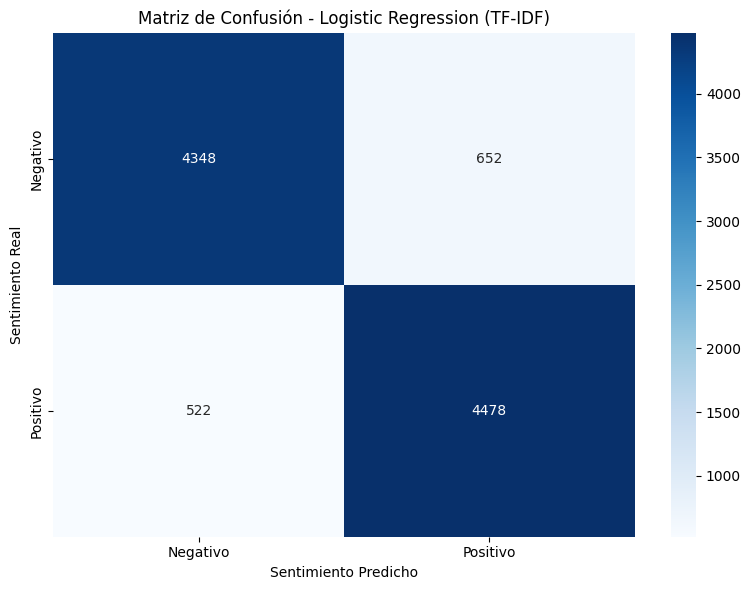


REPORTE DE CLASIFICACIÓN DETALLADO
              precision    recall  f1-score   support

    Negativo       0.89      0.87      0.88      5000
    Positivo       0.87      0.90      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
# Seleccionar el mejor modelo (usaremos Logistic Regression con TF-IDF como ejemplo)
mejor_modelo = resultados_tfidf['Logistic Regression']['modelo']
y_pred_mejor = resultados_tfidf['Logistic Regression']['y_pred']

print("=" * 60)
print("EVALUACIÓN DETALLADA: Logistic Regression con TF-IDF")
print("=" * 60)

# Matriz de confusión
cm = confusion_matrix(y_test_tfidf, y_pred_mejor)
print("\nMatriz de Confusión:")
print(cm)
print("\nInterpretación:")
print(f"  Verdaderos Negativos (TN): {cm[0][0]} - Predijo negativo y era negativo")
print(f"  Falsos Positivos (FP): {cm[0][1]} - Predijo positivo pero era negativo")
print(f"  Falsos Negativos (FN): {cm[1][0]} - Predijo negativo pero era positivo")
print(f"  Verdaderos Positivos (TP): {cm[1][1]} - Predijo positivo y era positivo")

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión - Logistic Regression (TF-IDF)')
plt.ylabel('Sentimiento Real')
plt.xlabel('Sentimiento Predicho')
plt.tight_layout()
plt.show()

# Reporte de clasificación completo
print("\n" + "=" * 60)
print("REPORTE DE CLASIFICACIÓN DETALLADO")
print("=" * 60)
print(classification_report(y_test_tfidf, y_pred_mejor, 
                        target_names=['Negativo', 'Positivo']))


### 7.1 Comparación Visual de Todos los Modelos


COMPARACIÓN COMPLETA DE TODOS LOS MODELOS
  Método              Modelo  Accuracy  Precision  Recall  F1-Score
     BoW         Naive Bayes    0.8431   0.847197  0.8372  0.842169
  TF-IDF         Naive Bayes    0.8517   0.837459  0.8728  0.854764
  TF-IDF Logistic Regression    0.8826   0.872904  0.8956  0.884107
  TF-IDF       Random Forest    0.8413   0.846357  0.8340  0.840133
Word2Vec Logistic Regression    0.8270   0.823250  0.8328  0.827998
Word2Vec       Random Forest    0.7958   0.788079  0.8092  0.798500


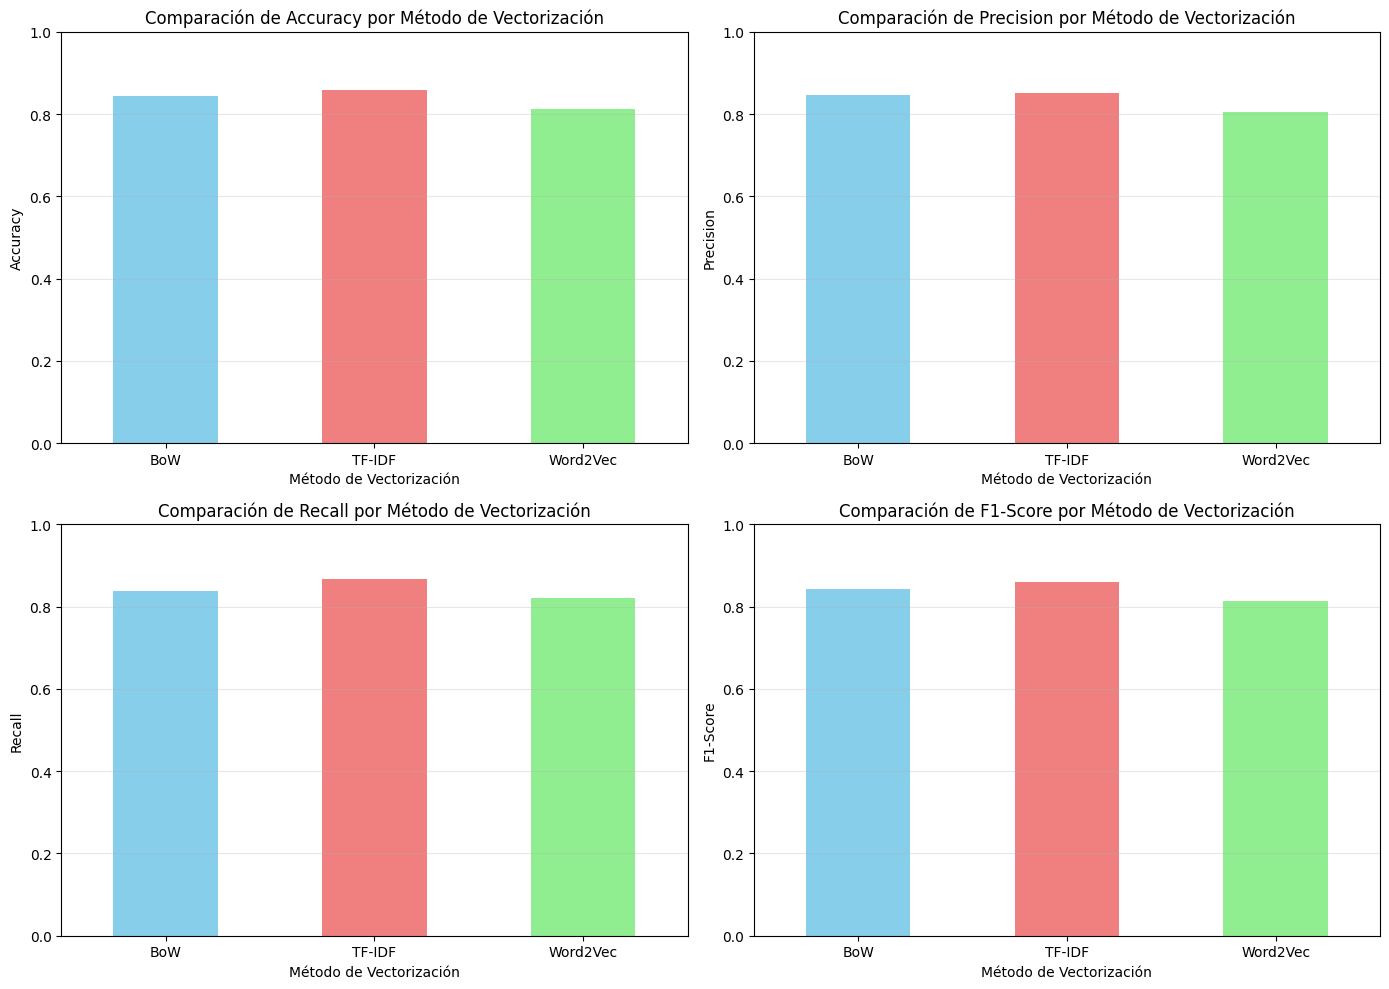


MEJOR MODELO GENERAL
Método de Vectorización: TF-IDF
Modelo: Logistic Regression
F1-Score: 0.8841
Accuracy: 0.8826


In [26]:
# Crear DataFrame con todos los resultados para comparación
resultados_completos = []

# Bag of Words
resultados_completos.append({
    'Método': 'BoW',
    'Modelo': 'Naive Bayes',
    'Accuracy': accuracy_bow,
    'Precision': precision_bow,
    'Recall': recall_bow,
    'F1-Score': f1_bow
})

# TF-IDF
for nombre, resultados in resultados_tfidf.items():
    resultados_completos.append({
        'Método': 'TF-IDF',
        'Modelo': nombre,
        'Accuracy': resultados['accuracy'],
        'Precision': resultados['precision'],
        'Recall': resultados['recall'],
        'F1-Score': resultados['f1']
    })

# Word2Vec
for nombre, resultados in resultados_w2v.items():
    resultados_completos.append({
        'Método': 'Word2Vec',
        'Modelo': nombre,
        'Accuracy': resultados['accuracy'],
        'Precision': resultados['precision'],
        'Recall': resultados['recall'],
        'F1-Score': resultados['f1']
    })

df_resultados = pd.DataFrame(resultados_completos)
print("=" * 60)
print("COMPARACIÓN COMPLETA DE TODOS LOS MODELOS")
print("=" * 60)
print(df_resultados.to_string(index=False))

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
métricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, métrica in enumerate(métricas):
    ax = axes[idx // 2, idx % 2]
    df_resultados.groupby('Método')[métrica].mean().plot(kind='bar', ax=ax, color=['skyblue', 'lightcoral', 'lightgreen'])
    ax.set_title(f'Comparación de {métrica} por Método de Vectorización')
    ax.set_ylabel(métrica)
    ax.set_xlabel('Método de Vectorización')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Mejor modelo general
mejor_fila = df_resultados.loc[df_resultados['F1-Score'].idxmax()]
print("\n" + "=" * 60)
print("MEJOR MODELO GENERAL")
print("=" * 60)
print(f"Método de Vectorización: {mejor_fila['Método']}")
print(f"Modelo: {mejor_fila['Modelo']}")
print(f"F1-Score: {mejor_fila['F1-Score']:.4f}")
print(f"Accuracy: {mejor_fila['Accuracy']:.4f}")


## 8. Predicción de Nuevos Textos

Ahora usaremos nuestro mejor modelo entrenado para predecir el sentimiento de nuevos textos que no estaban en el conjunto de entrenamiento.


In [27]:
def predecir_sentimiento(texto, modelo, vectorizador, word2vec_model=None, usar_w2v=False):
    """
    Predice el sentimiento de un nuevo texto usando el modelo entrenado.
    
    Parámetros:
    -----------
    texto : str
        Texto a analizar
    modelo : sklearn model
        Modelo entrenado
    vectorizador : sklearn vectorizer
        Vectorizador entrenado (TF-IDF o BoW)
    word2vec_model : Word2Vec, optional
        Modelo Word2Vec si se usa embeddings
    usar_w2v : bool
        Si True, usa Word2Vec; si False, usa el vectorizador
    
    Retorna:
    --------
    dict
        Diccionario con la predicción y probabilidades
    """
    # Preprocesar el texto (mismo proceso que en el entrenamiento)
    texto_limpio = limpiar_texto(texto)
    tokens = tokenizar(texto_limpio)
    tokens_sin_stop = eliminar_stopwords(tokens)
    tokens_lematizados = lematizar(tokens_sin_stop)
    texto_preprocesado = ' '.join(tokens_lematizados)
    
    # Vectorizar
    if usar_w2v and word2vec_model:
        vector = documento_a_vector(tokens_lematizados, word2vec_model).reshape(1, -1)
    else:
        vector = vectorizador.transform([texto_preprocesado])
    
    # Predecir
    prediccion = modelo.predict(vector)[0]
    
    # Obtener probabilidades (si el modelo las soporta)
    try:
        probabilidades = modelo.predict_proba(vector)[0]
        prob_negativa = probabilidades[0]
        prob_positiva = probabilidades[1]
    except:
        prob_negativa = None
        prob_positiva = None
    
    resultado = {
        'texto_original': texto,
        'texto_preprocesado': texto_preprocesado,
        'sentimiento_predicho': 'Positivo' if prediccion == 1 else 'Negativo',
        'sentimiento_numerico': int(prediccion),
        'probabilidad_negativa': prob_negativa,
        'probabilidad_positiva': prob_positiva
    }
    
    return resultado

print("✓ Función de predicción creada")


✓ Función de predicción creada


### 8.1 Ejemplos de Predicción


In [28]:
# Nuevos textos para predecir
nuevos_textos = [
    "This movie is absolutely amazing! I loved every single moment. The acting was superb and the story was captivating.",
    "What a terrible film. Boring plot, bad acting, and a waste of time. I would not recommend this to anyone.",
    "It was okay. Nothing special but not terrible either. Average movie with average performances.",
    "Fantastic! One of the best movies I've ever seen. The cinematography is stunning.",
    "I really enjoyed this film. The characters were well-developed and the plot kept me engaged throughout.",
    "Poor movie. Very disappointing. The script was weak and the dialogue was cringe-worthy."
]

print("=" * 60)
print("PREDICCIONES DE SENTIMIENTO PARA NUEVOS TEXTOS")
print("=" * 60)

# Usar el mejor modelo (Logistic Regression con TF-IDF)
for i, texto in enumerate(nuevos_textos, 1):
    resultado = predecir_sentimiento(texto, mejor_modelo, tfidf_vectorizer)
    
    print(f"\n{'='*60}")
    print(f"TEXTO {i}")
    print(f"{'='*60}")
    print(f"Texto original:")
    print(f"  {texto}")
    print(f"\nSentimiento predicho: {resultado['sentimiento_predicho']}")
    if resultado['probabilidad_positiva'] is not None:
        print(f"Confianza:")
        print(f"  Probabilidad Negativa: {resultado['probabilidad_negativa']:.4f} ({resultado['probabilidad_negativa']*100:.2f}%)")
        print(f"  Probabilidad Positiva: {resultado['probabilidad_positiva']:.4f} ({resultado['probabilidad_positiva']*100:.2f}%)")
    print(f"\nTexto preprocesado:")
    print(f"  {resultado['texto_preprocesado'][:150]}...")


PREDICCIONES DE SENTIMIENTO PARA NUEVOS TEXTOS

TEXTO 1
Texto original:
  This movie is absolutely amazing! I loved every single moment. The acting was superb and the story was captivating.

Sentimiento predicho: Positivo
Confianza:
  Probabilidad Negativa: 0.0271 (2.71%)
  Probabilidad Positiva: 0.9729 (97.29%)

Texto preprocesado:
  movie absolutely amaze love every single moment act superb story captivate...

TEXTO 2
Texto original:
  What a terrible film. Boring plot, bad acting, and a waste of time. I would not recommend this to anyone.

Sentimiento predicho: Negativo
Confianza:
  Probabilidad Negativa: 1.0000 (100.00%)
  Probabilidad Positiva: 0.0000 (0.00%)

Texto preprocesado:
  terrible film boring plot bad act waste time would recommend anyone...

TEXTO 3
Texto original:
  It was okay. Nothing special but not terrible either. Average movie with average performances.

Sentimiento predicho: Negativo
Confianza:
  Probabilidad Negativa: 0.9517 (95.17%)
  Probabilidad Positiva: 0.

### 8.2 Función Interactiva para Predicción

Crearemos una función que permite al usuario ingresar su propio texto y obtener una predicción.


In [ ]:
def analizar_sentimiento_interactivo(texto_usuario):
    """
    Función interactiva para analizar el sentimiento de un texto ingresado por el usuario.
    
    Parámetros:
    -----------
    texto_usuario : str
        Texto ingresado por el usuario
    """
    print("\n" + "="*70)
    print("ANÁLISIS DE SENTIMIENTO")
    print("="*70)
    
    resultado = predecir_sentimiento(texto_usuario, mejor_modelo, tfidf_vectorizer)
    
    print(f"\n📝 Texto ingresado:")
    print(f"   {texto_usuario}")
    print(f"\n🎯 Sentimiento predicho: {resultado['sentimiento_predicho']}")
    
    if resultado['probabilidad_positiva'] is not None:
        print(f"\n📊 Confianza de la predicción:")
        print(f"   Positivo: {resultado['probabilidad_positiva']*100:.2f}%")
        print(f"   Negativo: {resultado['probabilidad_negativa']*100:.2f}%")
        
        # Visualización simple
        if resultado['sentimiento_numerico'] == 1:
            barra = "█" * int(resultado['probabilidad_positiva'] * 50)
            print(f"\n   [{barra}] {resultado['probabilidad_positiva']*100:.1f}% Positivo")
        else:
            barra = "█" * int(resultado['probabilidad_negativa'] * 50)
            print(f"\n   [{barra}] {resultado['probabilidad_negativa']*100:.1f}% Negativo")
    
    print("\n" + "="*70)
    
    return resultado

# Ejemplo de uso (descomentar para usar interactivamente)
# texto = input("Ingresa un texto para analizar su sentimiento: ")
# analizar_sentimiento_interactivo(texto)

# Demostración con un texto de ejemplo
print("Ejemplo de uso de la función interactiva:")
ejemplo_usuario = "I expect no one to watch this movie. It's a waste of time."
analizar_sentimiento_interactivo(ejemplo_usuario)


Ejemplo de uso de la función interactiva:

ANÁLISIS DE SENTIMIENTO

📝 Texto ingresado:
   I expect no one to watch this movie. It's a waste of time.

🎯 Sentimiento predicho: Negativo

📊 Confianza de la predicción:
   Positivo: 1.61%
   Negativo: 98.39%

   [█████████████████████████████████████████████████] 98.4% Negativo



{'texto_original': "I expect no one to watch this movie. It's a waste of time.",
 'texto_preprocesado': "expect one watch movie 's waste time",
 'sentimiento_predicho': 'Negativo',
 'sentimiento_numerico': 0,
 'probabilidad_negativa': np.float64(0.9838843983855821),
 'probabilidad_positiva': np.float64(0.016115601614417958)}

## 9. Resumen y Conclusiones

### Resumen del Proyecto

Este notebook ha demostrado un flujo completo de análisis de sentimientos que incluye:

1. **Preprocesamiento de texto**: Limpieza, tokenización, eliminación de stopwords y lematización
2. **Vectorización**: Implementación de Bag of Words, TF-IDF y Word Embeddings (Word2Vec)
3. **Entrenamiento de modelos**: Múltiples algoritmos de machine learning (Naive Bayes, Logistic Regression, Random Forest)
4. **Evaluación**: Métricas completas (accuracy, precision, recall, F1-score) y matrices de confusión
5. **Predicción**: Sistema para predecir sentimientos de nuevos textos

### Puntos Clave Aprendidos

- **Preprocesamiento es crucial**: La calidad del preprocesamiento afecta directamente el rendimiento del modelo
- **TF-IDF generalmente funciona mejor** que Bag of Words para tareas de clasificación de texto
- **Word Embeddings** capturan relaciones semánticas pero requieren más datos y cómputo
- **La elección del modelo** depende del contexto: Logistic Regression suele ser un buen punto de partida
- **Las métricas de evaluación** son esenciales para entender el rendimiento real del modelo

### Próximos Pasos Sugeridos

- Experimentar con modelos más avanzados (BERT, Transformers)
- Ajustar hiperparámetros de los modelos
- Implementar validación cruzada para una evaluación más robusta
- Probar con otros datasets de diferentes dominios
- Implementar técnicas de balanceo de clases si es necesario


In [31]:
# Guardar los modelos y vectorizadores para uso futuro (opcional)
import pickle

# Crear diccionario con todos los componentes necesarios para predicción
modelo_guardar = {
    'modelo': mejor_modelo,
    'vectorizador': tfidf_vectorizer,
    'word2vec_model': word2vec_model,
    'metadatos': {
        'mejor_metodo': 'TF-IDF',
        'mejor_modelo': 'Logistic Regression',
        'accuracy': mejor_fila['Accuracy'],
        'f1_score': mejor_fila['F1-Score']
    }
}

print("Modelo y componentes guardados en memoria.")
print("Para guardar en disco, descomentar las siguientes líneas:")
print("""
with open('modelo_sentimientos.pkl', 'wb') as f:
    pickle.dump(modelo_guardar, f)
print('Modelo guardado en modelo_sentimientos.pkl')
""")

print("\n" + "="*70)
print("¡ANÁLISIS DE SENTIMIENTOS COMPLETADO!")
print("="*70)


Modelo y componentes guardados en memoria.
Para guardar en disco, descomentar las siguientes líneas:

with open('modelo_sentimientos.pkl', 'wb') as f:
    pickle.dump(modelo_guardar, f)
print('Modelo guardado en modelo_sentimientos.pkl')


¡ANÁLISIS DE SENTIMIENTOS COMPLETADO!
